## 1. Подготовка данных

### Импорт библиотек, визуализация исходных таблиц, объединение тестового и тренировочного датасетов и тд


In [342]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Библиотека для нормализации/масштабирования
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler # инструмент для масштабирования каждой функции до заданного диапазона

# Импортируем необходимые библиотеки для регрессионного анализа:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.feature_selection import chi2 # хи-квадрат
# Библиотеки для сентиментного анализа текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [343]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [344]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [345]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [346]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [347]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [348]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [349]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [350]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [351]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [352]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [353]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [354]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [355]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


## 1. Проектирование признаков (Feature Engineering)

### 1.1 Географическое расположение

In [356]:
data['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

In [357]:
#Выделим название города и страны из адреса:
# Обратим внимание, что страна United Kingdom во-первых состоит из двух слов, 
# во-вторых в таких строках с этой страной, название города
# разделено с названием страны двумя дополнительным обозначениями, которые нам не нужны
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1])
data['hotel_country'] = data['hotel_country'].apply(lambda x:'United Kingdom' if x == 'Kingdom' else x)
country_list = list(data['hotel_country'].unique()) # в датасете отели из 6 стран
display(country_list)
data['city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])
city = list(data['city'].unique())
city# и 6 городов-столиц

['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France', 'Austria']

['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna']

In [358]:
# Заполним координаты отеля модой значения координат города

for city in list(data['city'].unique()):
    #mode_lat = 5
    mode_lat = data[(data['city'] == city) & data.lat > 0].lat.mode()
    mode_lng = data[(data['city'] == city) & data.lng > 0].lng.mode()
    data[data['city'] == city]['lat'] = data['lat'].fillna(mode_lat[0], inplace=True)
    data[data['city'] == city]['lng'] = data['lng'].fillna(mode_lat[0], inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [359]:
encoder = ce.OneHotEncoder(cols=['hotel_country']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['city'])
data = pd.concat([data, type_bin], axis=1)


### 1.2 Анализ дат

In [360]:
#Переведем каждый компонент даты (год, месяц, день) в число и выделим для каждого отдельный признак
data['month']=pd.to_datetime(data['review_date']).dt.month
data['year']=pd.to_datetime(data['review_date']).dt.year
data['day']=pd.to_datetime(data['review_date']).dt.day

In [361]:
#переведем признак days_since_review в числовой
data.days_since_review=data.days_since_review.apply(lambda x: x.replace('days',''))
data.days_since_review=data.days_since_review.apply(lambda x: x.replace('day',''))
data.days_since_review=data.days_since_review.apply(lambda x: x.replace(' ',''))
data.days_since_review=data.days_since_review.astype('int')
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)
data.drop(['reviewer_nationality'],axis=1,inplace=True)

### 1.3 Анализ тегов

In [362]:
#для выполнения задания и для понимания, что в тегах находится зададим словарь и туда занесем все найденные теги
data.tags=data.tags.apply(lambda x: x[1:-1].split(","))
dictionary={}
for i in data.tags:
    for y in range(len(i)):
        i[y]=i[y].replace('[', '').replace(']', '').replace("'", '').strip()
        if i[y] in dictionary:
            dictionary[i[y]]+=1
        else:
            dictionary[i[y]]=0

print(len(dictionary))
print(max(dictionary, key=dictionary.get))
print(max(dictionary.values()))

2428
Leisure trip
417777


In [363]:
display((sorted(dictionary.items(), key=lambda x: x[1], reverse=True))[0:20])
#пробовал что-то полезное вытащить из тегов, но ничем хорошим это не закончилось, так что теги не трогаю

[('Leisure trip', 417777),
 ('Submitted from a mobile device', 307639),
 ('Couple', 252293),
 ('Stayed 1 night', 193644),
 ('Stayed 2 nights', 133936),
 ('Solo traveler', 108544),
 ('Stayed 3 nights', 95820),
 ('Business trip', 82938),
 ('Group', 65391),
 ('Family with young children', 61014),
 ('Stayed 4 nights', 47816),
 ('Double Room', 35206),
 ('Standard Double Room', 32247),
 ('Superior Double Room', 31392),
 ('Family with older children', 26348),
 ('Deluxe Double Room', 24822),
 ('Double or Twin Room', 22392),
 ('Stayed 5 nights', 20844),
 ('Standard Double or Twin Room', 17482),
 ('Classic Double Room', 16988)]

## 1.4 Анализ количества комментариев

In [364]:
# Понравилось у Константина Пензина https://www.kaggle.com/code/constantinvp/project-3
# Вычислим долю слов положительных комментариев среди всех комментариев. 
# Пометим строку, если количество слов в пложительном комментарии преобладает над количеством слов в отрицательном.

data['review_total_positive_word_counts_norm']  = pd.DataFrame(
    MinMaxScaler().fit_transform(pd.DataFrame(
        data['review_total_positive_word_counts'])),
    columns=['review_total_positive_word_counts'])

data['review_total_negative_word_counts_norm']  = pd.DataFrame(
    MinMaxScaler().fit_transform(pd.DataFrame(data['review_total_negative_word_counts'])),
    columns=['review_total_negative_word_counts'])

data['review_total_word_diff_norm'] =  \
    data['review_total_positive_word_counts_norm'] - \
    data['review_total_negative_word_counts_norm']

data['more_positive'] = data['review_total_word_diff_norm'].apply(lambda x: 1 if x >= 0 else 0)

data.drop(
    ['review_total_positive_word_counts_norm', 'review_total_negative_word_counts_norm'], 
    axis=1, inplace=True)

data['review_total_word_sum'] = \
    data['review_total_positive_word_counts'] + \
    data['review_total_negative_word_counts']

# пополам отрицательных и положительных
data['positive_words_proportion'] = data.apply( lambda x: 0.5 if x['review_total_word_sum'] == 0 \
    else x['review_total_positive_word_counts'] / x['review_total_word_sum'],axis=1)

data.drop('review_total_word_sum', axis = 1, inplace=True)

## 1.5 Анализ сантимента текста

In [365]:
#Для глубокого анализа отзывов (из структуры, эмоциональной окраски, качества) воспользуемся библиотекой VADER (класс SentimentIntensityAnalyzer) из библиотеки NLTK. 
#Подробно можно почитать здесь: http://espressocode.top/python-sentiment-analysis-using-vader/.

In [366]:
#посмотрим, какие значения есть в поле negative_review и positive_review

data['negative_review_neg']=data.negative_review.apply(lambda x: x[:].split(","))
dictionary_neg={}
for i in data.negative_review_neg:
    for y in range(len(i)):
        i[y]=i[y].replace('[', '').replace(']', '').replace("'", '').strip()
        if i[y] in dictionary_neg:
            dictionary_neg[i[y]]+=1
        else:
            dictionary_neg[i[y]]=0

In [367]:
sorted(dictionary_neg.items(), key=lambda x: x[1], reverse=True)[0:30]

[('No Negative', 127889),
 ('Nothing', 18530),
 ('nothing', 2507),
 ('None', 1165),
 ('N A', 1059),
 ('', 848),
 ('Nothing really', 569),
 ('N a', 519),
 ('All good', 469),
 ('Small room', 454),
 ('No complaints', 449),
 ('Breakfast', 448),
 ('Location', 420),
 ('Nothing at all', 414),
 ('Everything', 366),
 ('Nothing to dislike', 334),
 ('none', 321),
 ('Price', 300),
 ('Nil', 268),
 ('Everything was perfect', 246),
 ('Small rooms', 244),
 ('Can t think of anything', 233),
 ('n a', 232),
 ('Leaving', 219),
 ('Absolutely nothing', 213),
 ('Everything was great', 202),
 ('Expensive', 180),
 ('Nothing to complain about', 177),
 ('Nothing not to like', 174),
 ('Room size', 155)]

In [368]:
data['positive_review_pos']=data.positive_review.apply(lambda x: x[:].split(","))
dictionary_pos={}
for i in data.positive_review_pos:
    for y in range(len(i)):
        i[y]=i[y].replace('[', '').replace(']', '').replace("'", '').strip()
        if i[y] in dictionary_pos:
            dictionary_pos[i[y]]+=1
        else:
            dictionary_pos[i[y]]=0

In [369]:
sorted(dictionary_pos.items(), key=lambda x: x[1], reverse=True)[0:30]

[('No Positive', 35945),
 ('Location', 10136),
 ('Everything', 2896),
 ('location', 1735),
 ('Nothing', 1467),
 ('Great location', 1418),
 ('The location', 1340),
 ('Good location', 1202),
 ('Breakfast', 663),
 ('Friendly staff', 602),
 ('Excellent location', 546),
 ('Staff', 485),
 ('Location and staff', 370),
 ('everything', 370),
 ('Location was great', 293),
 ('Location was good', 276),
 ('Everything was perfect', 275),
 ('Comfy bed', 262),
 ('Good breakfast', 247),
 ('Location is great', 235),
 ('nothing', 233),
 ('The staff', 233),
 ('Perfect location', 226),
 ('good location', 224),
 ('Location location location', 217),
 ('Location staff', 214),
 ('Location is good', 213),
 ('Breakfast was good', 197),
 ('the location', 194),
 ('Very friendly staff', 193)]

In [370]:
# Часть кода взял у https://www.kaggle.com/code/margaritakr/project-3-booking-com-margaritak, так как там хорошо описаны
# разные варианты, когда одно и то же слово, может значить положительный или негативный отзыв в зависимости от того,
# в каком признаке это слово встречается
data['negative_review_temp'] = data['negative_review'].apply(
    lambda x: x.replace('No Negative', 'Positive'))
data['negative_review_temp'] = data['negative_review_temp'].apply(
    lambda x: x.replace('N A', 'Positive'))
data['negative_review_temp'] = data['negative_review_temp'].apply(
    lambda x: x.replace('All good', 'Positive'))
data['negative_review_temp'] = data['negative_review_temp'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
data['negative_review_temp'] = data['negative_review_temp'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
data['positive_review_temp'] = data['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

In [371]:
positive_sia = SentimentIntensityAnalyzer()
negative_sia = SentimentIntensityAnalyzer()

# добавим контекст:
negative_words = {'small': -1, 'nothing': 10}
positive_words = {'nothing': -10, 'everything': 10}
positive_sia.lexicon.update(negative_words)
negative_sia.lexicon.update(positive_words)

data['negative_review_sentiments'] = data['negative_review_temp'].apply(
    lambda x: negative_sia.polarity_scores(x))
data['positive_review_sentiments'] = data['positive_review_temp'].apply(
    lambda x: positive_sia.polarity_scores(x))

# формируем новые признаки:
data['n_review_sentiments_neg'] = data['negative_review_sentiments'].apply(
    lambda x: x['neg'])
# hotels['n_review_sentiments_neu'] = hotels['negative_review_sentiments'].apply(
#     lambda x: x['neu'])
data['n_review_sentiments_pos'] = data['negative_review_sentiments'].apply(
    lambda x: x['pos'])
data['n_review_sentiments_compound'] = data['negative_review_sentiments'].apply(
    lambda x: x['compound'])

data['p_review_sentiments_neg'] = data['positive_review_sentiments'].apply(
    lambda x: x['neg'])
# hotels['p_review_sentiments_neu'] = hotels['positive_review_sentiments'].apply(
#     lambda x: x['neu'])
data['p_review_sentiments_pos'] = data['positive_review_sentiments'].apply(
    lambda x: x['pos'])
data['p_review_sentiments_compound'] = data['positive_review_sentiments'].apply(
    lambda x: x['compound'])


## 2. Нормализация, стандартизация

Думал о нормализации признаков с помощью minmaxscaler, robustscaler, потом изучил как работает Random Forrest алгоритм и везде пишут примерно такое (дословно):'**data normalization won’t affect the output for Random Forest classifiers while it will affect the output for Random Forest regressors**. Так как у нас используется Regressor, то нормализацию произвести надо.

In [372]:
# Копируем названия столбцов, которые теряются при использовании fit_transform()
#col_names = list(data.columns)
col_names = [ 'additional_number_of_scoring',
'average_score',
'review_total_negative_word_counts',
'total_number_of_reviews',
'review_total_positive_word_counts', 
'total_number_of_reviews_reviewer_has_given',
'days_since_review']
# копируем индексы
ind = data.index

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# копируем исходный датасет
df_r = r_scaler.fit_transform(data[col_names])

df_r = pd.DataFrame(df_r, columns=col_names, index= ind)
# перезаписываем нормализированные признаки
data[col_names] = df_r[col_names]
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,negative_review_temp,positive_review_temp,negative_review_sentiments,positive_review_sentiments,n_review_sentiments_neg,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_pos,p_review_sentiments_compound
0,Via Senigallia 6 20161 Milan Italy,1.146640,7/21/2017,-0.428571,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,2.047619,5.928222,Hotel was great clean friendly staff free bre...,3.000000,...,Would have appreciated a shop in the hotel th...,Hotel was great clean friendly staff free bre...,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.129,0.125,-0.0554,0.0,0.329,0.9615
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,0.551935,12/12/2016,0.285714,Urban Lodge Hotel,No tissue paper box was present at the room,0.047619,1.176183,No Positive,-0.647059,...,No tissue paper box was present at the room,Negative,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...","{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.216,0.000,-0.2960,1.0,0.000,-0.5719
2,Mallorca 251 Eixample 08008 Barcelona Spain,-0.600815,11/26/2015,-0.142857,Alexandra Barcelona A DoubleTree by Hilton,Pillows,-0.285714,-0.727162,Nice welcoming and service,-0.352941,...,Pillows,Nice welcoming and service,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...",0.000,0.000,0.0000,0.0,0.740,0.6908
3,Piazza Della Repubblica 17 Central Station 201...,-0.203666,10/17/2015,1.000000,Hotel Principe Di Savoia,No Negative,-0.428571,-0.241028,Everything including the nice upgrade The Hot...,0.941176,...,Positive,Everything including the nice upgrade The Hot...,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","{'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...",0.000,1.000,0.5574,0.0,0.379,0.9153
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,1.004073,5/16/2016,1.000000,Hotel Esther a,No Negative,-0.428571,1.041191,Lovely hotel v welcoming staff,-0.235294,...,Positive,Lovely hotel v welcoming staff,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","{'neg': 0.0, 'neu': 0.23, 'pos': 0.77, 'compou...",0.000,1.000,0.5574,0.0,0.770,0.7717


## 3. Отбор признаков
### 3.1 Очистка датасета от неинформативных и вспомогательных признаков

In [373]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

# также избавимся от других нечисловых признаков: category, datetime64[ns]
cat_date_columns = [cd for cd in data.columns if ((data[cd].dtypes.name == 'category') or (data[cd].dtypes == 'datetime64[ns]'))]
data.drop(cat_date_columns, axis = 1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 43 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  float64
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  float64
 3   total_number_of_reviews                     515738 non-null  float64
 4   review_total_positive_word_counts           515738 non-null  float64
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 6   days_since_review                           515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

### 3.2 Анализ мультиколлинеарности

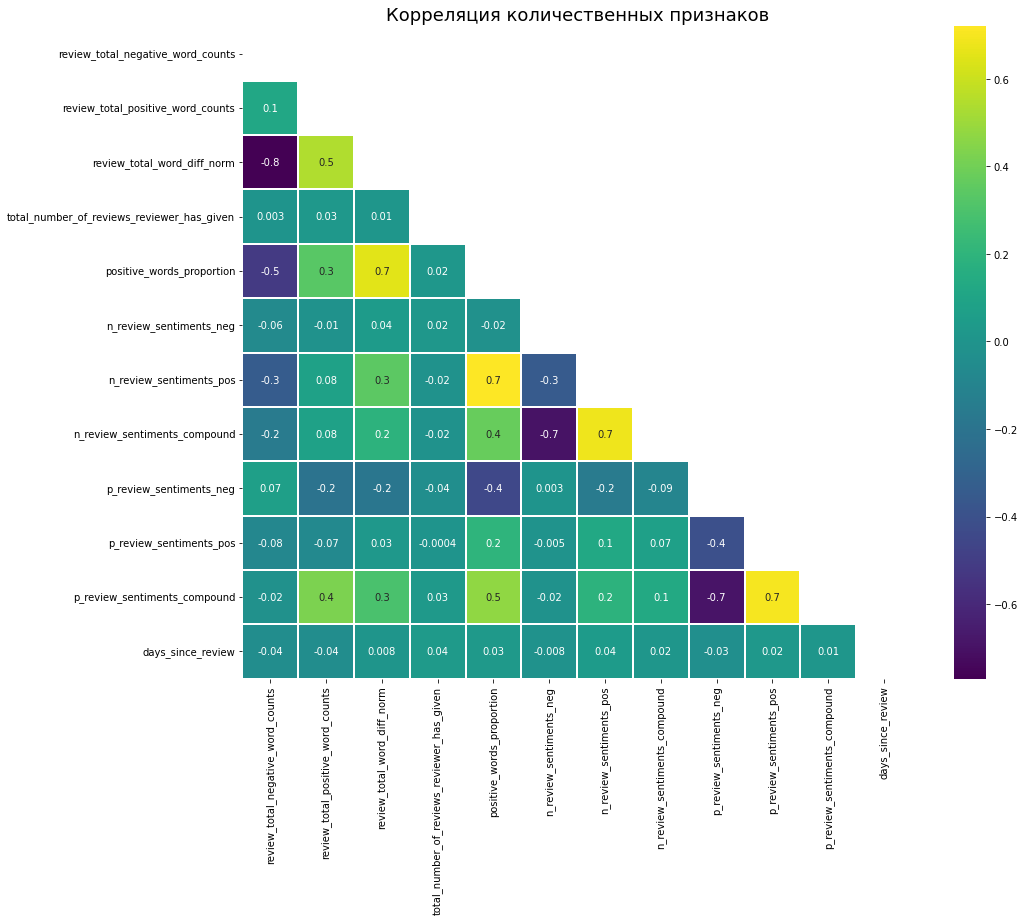

In [374]:
#Разделим признаки по типу
#Количественные
cols_num = [
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'review_total_word_diff_norm',
    'total_number_of_reviews_reviewer_has_given',
    'positive_words_proportion',
    'n_review_sentiments_neg',
    'n_review_sentiments_pos',
    'n_review_sentiments_compound',
    'p_review_sentiments_neg',
    'p_review_sentiments_pos',
    'p_review_sentiments_compound',
    'days_since_review',
]
#Категориальные
cols_cat = [
    'lat',
    'lng',
    'additional_number_of_scoring',
    'average_score',
    'total_number_of_reviews',
    'days_since_review',
    'month',
    'year',
    'day',
    'more_positive',
    'reviewer_nationality_0',
    'reviewer_nationality_1',
    'reviewer_nationality_2',
    'reviewer_nationality_3',
    'reviewer_nationality_4',
    'reviewer_nationality_5',
    'reviewer_nationality_6',
    'reviewer_nationality_7',
    'city_1',
    'city_2',
    'city_3',
    'city_4',
    'city_5',
    'city_6',
    'hotel_country_1',
    'hotel_country_2',
    'hotel_country_3',
    'hotel_country_4',
    'hotel_country_5',
    'hotel_country_6',
]
#Построим тепловую диаграмму корреляции количественных признаков
fig_, ax_ = plt.subplots(figsize=(15, 12))
corr = data[cols_num].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_, 
            mask=mask, 
            cmap='viridis',
            fmt='.1g')
ax_.set_title('Корреляция количественных признаков', fontsize=18)
plt.show()

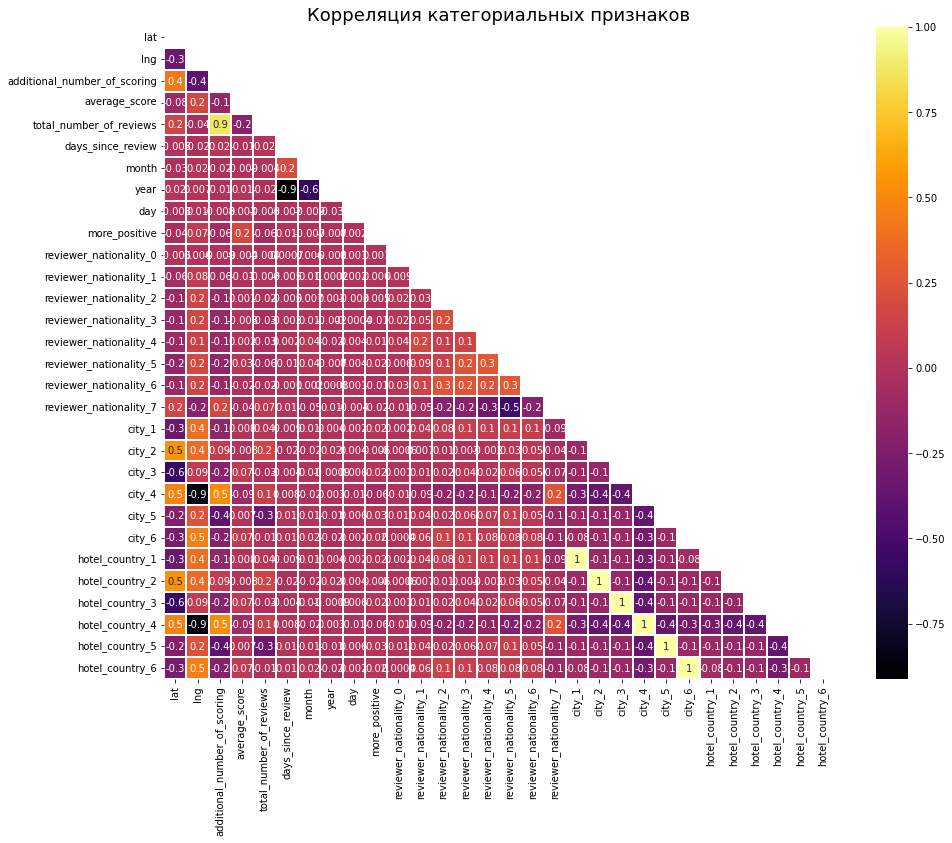

In [375]:
#Построим тепловую диаграмму корреляции категориальных признаков
fig_, ax_ = plt.subplots(figsize=(15, 12))
corr = data[cols_cat].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_, 
            mask=mask, 
            cmap='inferno',
            fmt='.1g')
ax_.set_title('Корреляция категориальных признаков', fontsize=18)
plt.show()

In [379]:
#Удалим признаки с корреляцией больше 0.75

data.drop(['year','hotel_country_4','city_4','review_total_word_diff_norm','total_number_of_reviews'], axis = 1, inplace=True)
print('Осталось признаков: {}'.format(data.shape[1]))

Осталось признаков: 38


## 2.3 Анализ значимости признаков

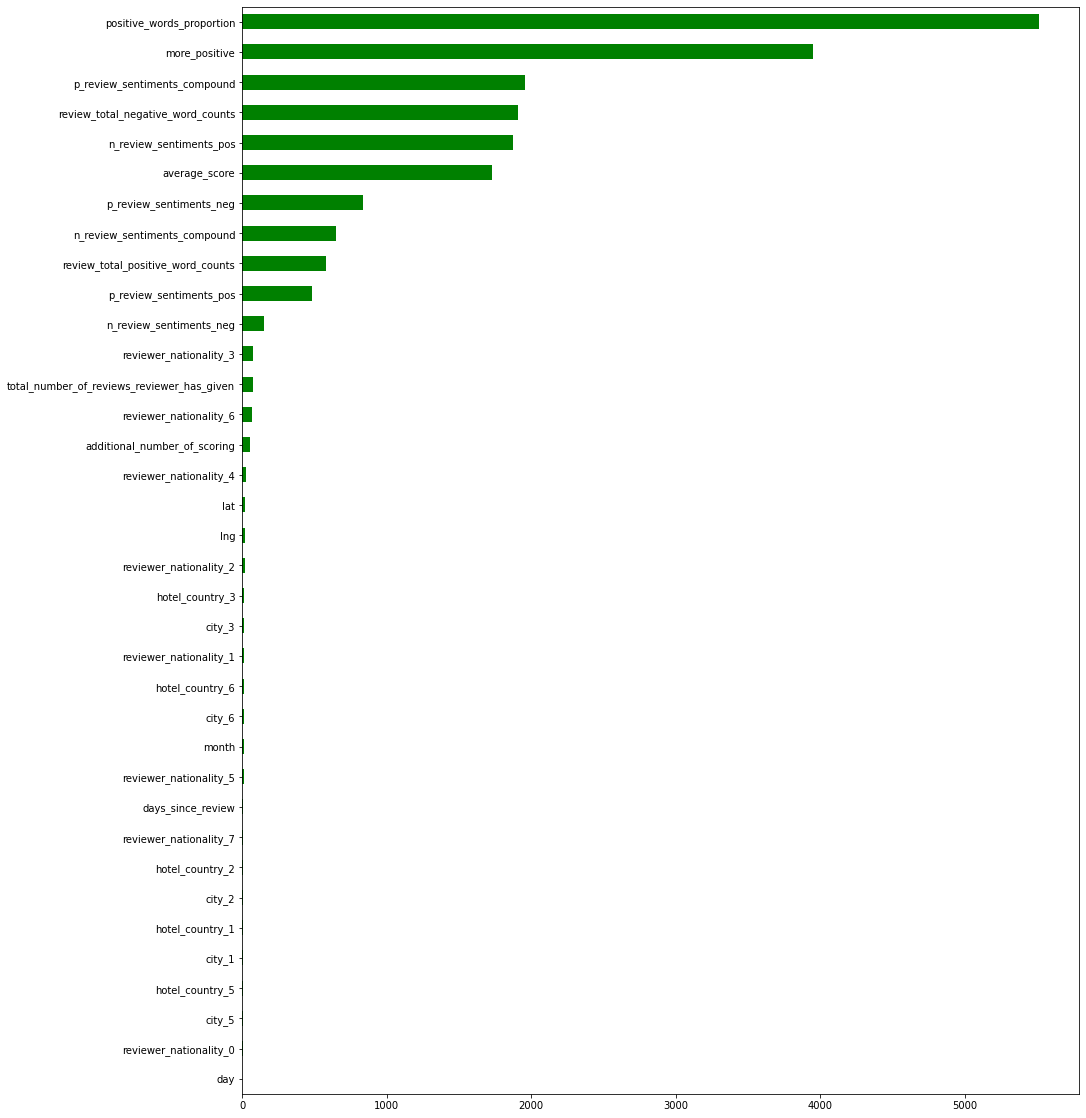

In [380]:
#Для оценки значимости признаков (суммарно по всей совокупности) будем использовать тест ANOVA:
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)
from sklearn.feature_selection import f_classif # anova
# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

Удалим признаки, не демонстрирующие никакой корреляции с целевым.

In [381]:
drop_columns = ['day', 'reviewer_nationality_0', 'city_5', 
                'hotel_country_5', 'hotel_country_1', 'city_1',
                'city_2',  'hotel_country_2', 
                'reviewer_nationality_7', 'days_since_review','month',
                'city_6','hotel_country_6','reviewer_nationality_1']
# удалим незначимые числовые данные:
print(f'Удалим {len(drop_columns)} столбцов с числовыми данными')
data.drop(drop_columns, axis = 1, inplace=True)

print(f'Итоговое получившееся количество признаков: {len(data.columns)}')
print('(включая столбец "Sample" и целевой столбец)')

Удалим 14 столбцов с числовыми данными
Итоговое получившееся количество признаков: 24
(включая столбец "Sample" и целевой столбец)


## 4. Обучение модели и получение предсказания 

In [382]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [383]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [384]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 23), (386803, 23), (386803, 22), (309442, 22), (77361, 22))

In [385]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [386]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


In [387]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Функция для вычисления MAPE
def mape_func(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
print(mape_func(y_test,y_pred))

12.44423372692378


<AxesSubplot:>

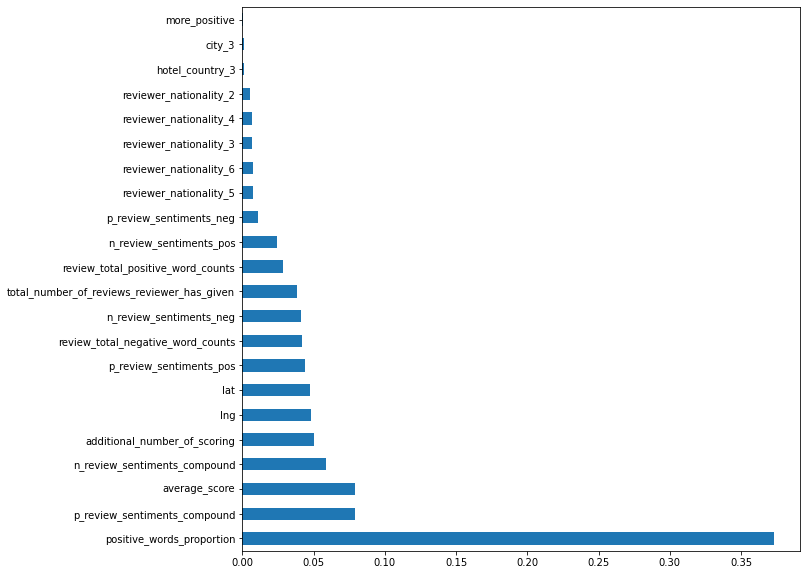

In [388]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [389]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,hotel_country_3,city_3,...,reviewer_nationality_5,reviewer_nationality_6,more_positive,positive_words_proportion,n_review_sentiments_neg,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_pos,p_review_sentiments_compound
1004,-0.439919,1.285714,-0.428571,2.235294,0.285714,52.370261,4.903249,0.0,0,0,...,0,1,1,1.000000,0.000,1.000,0.5574,0.065,0.299,0.9364
97586,2.329939,-1.285714,1.238095,-0.176471,-0.285714,51.519569,-0.170521,0.0,0,0,...,0,1,0,0.186047,0.000,0.156,0.6124,0.000,0.451,0.6249
105348,-0.401222,0.000000,0.000000,-0.352941,0.285714,48.235379,16.421974,0.0,0,0,...,0,1,0,0.357143,0.000,0.000,0.0000,0.000,0.000,0.0000
1091,-0.132383,0.428571,1.476190,-0.294118,0.428571,51.515647,-0.157244,0.0,0,0,...,0,0,0,0.130435,0.086,0.000,-0.5096,0.000,0.000,0.0000
35490,-0.183299,0.571429,2.619048,8.000000,2.285714,48.191339,16.316587,0.0,0,0,...,1,1,1,0.696682,0.113,0.215,0.8965,0.019,0.230,0.9859
107795,0.452138,-0.142857,-0.428571,2.176471,0.000000,45.525722,9.215003,0.0,0,0,...,0,0,1,1.000000,0.000,1.000,0.5574,0.000,0.321,0.9477
11773,-0.346232,-0.428571,-0.428571,0.058824,1.714286,51.519793,-0.124184,0.0,0,0,...,1,1,1,1.000000,0.000,1.000,0.5574,0.000,0.433,0.7269
98622,-0.592668,1.000000,1.380952,4.294118,0.428571,48.879537,2.320297,0.0,0,0,...,1,1,1,0.688525,0.051,0.421,0.9783,0.020,0.379,0.9883
116843,0.531568,0.142857,0.619048,-0.235294,-0.285714,51.506935,-0.126012,0.0,0,0,...,0,0,0,0.241379,0.128,0.000,-0.4215,0.000,0.398,0.5106
36927,0.435845,0.000000,-0.095238,-0.117647,0.857143,52.346645,4.831098,0.0,0,0,...,1,0,1,0.562500,0.000,0.000,0.0000,0.000,0.567,0.7620


In [390]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [391]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [392]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


In [393]:
predict_submission

array([8.777, 7.607, 8.025, ..., 8.339, 9.538, 7.785])

In [394]:
list(sample_submission)

['reviewer_score', 'id']

In [395]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.7770,488440
1,7.6070,274649
2,8.0250,374688
3,9.7820,404352
4,9.5728,451596
5,8.9650,302161
6,7.4060,317079
7,7.6990,13963
8,8.8610,159785
9,7.6230,195089
